# 4.5 練習問題

In [1]:
ENV["LINES"] = 10
ENV["COLUMNS"] = 1000

1000

In [2]:
using DataFrames, DataFramesMeta, CSV, GLM, Dates, Statistics, Gadfly

## 4.5.1

In [3]:
intrade08_df = CSV.read("../../data/PREDICTION/betting-markets/data/intrade08.csv", DataFrame; missingstring=["NA"])
intrade12_df = CSV.read("../../data/PREDICTION/betting-markets/data/intrade12.csv", DataFrame; missingstring=["NA"])
pres08_df = CSV.read("../../data/PREDICTION/betting-markets/data/pres08.csv", DataFrame; missingstring=["NA"])
pres12_df = CSV.read("../../data/PREDICTION/betting-markets/data/pres12.csv", DataFrame; missingstring=["NA"])
polls08_df = CSV.read("../../data/PREDICTION/betting-markets/data/polls08.csv", DataFrame; missingstring=["NA"])
polls12_df = CSV.read("../../data/PREDICTION/betting-markets/data/polls12.csv", DataFrame; missingstring=["NA"])

,state,Obama,Romney,Pollster,middate
,String3,Int64,Int64,String,Date
1,AL,36,51,Capital Survey Research Center,2012-06-27
2,AZ,46,53,PPP (D),2012-11-03
3,AZ,44,52,YouGov,2012-11-03
4,AZ,44,52,Rasmussen/CBS 5,2012-10-21
5,AZ,43,52,YouGov,2012-10-11
6,AZ,42,40,Behavior Research Center,2012-10-10
7,AZ,44,53,PPP (D),2012-10-03
8,AZ,42,46,Moore Information (R-HighGround),2012-09-26
9,AZ,42,52,Rasmussen,2012-09-25


In [4]:
describe(intrade08_df, :all)

,variable,mean,std,min,q25,median,q75,max,nunique,nmissing,first,last,eltype
,Symbol,Union…,Union…,Any,Any,Any,Any,Any,Union…,Int64,Any,Any,DataType
1,day,,,2006-11-12,2007-05-12,2007-11-09,2008-05-08,2008-11-19,738,0,2006-11-12,2008-11-19,Date
2,statename,,,Alabama,,,,Wyoming,51,0,Alabama,Missouri,String31
3,PriceD,46.7751,33.5662,0.0,12.5,43.0,82.5,99.9,,0,40.0,0.0,Float64
4,VolumeD,6.40045,130.009,0,0.0,0.0,0.0,17353,,0,0,2199,Int64
5,PriceR,51.2651,33.6962,0.0,15.2,51.0,85.0,99.5,,0,40.0,0.0,Float64
6,VolumeR,5.58255,116.191,0,0.0,0.0,0.0,14885,,0,0,544,Int64
7,state,,,AK,,,,WY,51,0,AL,MO,String3


In [5]:
describe(pres08_df, :all)

,variable,mean,std,min,q25,median,q75,max,nunique,nmissing,first,last,eltype
,Symbol,Union…,Union…,Any,Union…,Union…,Union…,Any,Union…,Int64,Any,Any,DataType
1,state.name,,,Alabama,,,,Wyoming,51,0,Alabama,Wyoming,String15
2,state,,,AK,,,,WY,51,0,AL,WY,String3
3,Obama,51.3725,11.0399,33,43.0,51.0,57.5,92,,0,39,33,Int64
4,McCain,47.0588,11.0425,7,40.0,47.0,56.0,66,,0,60,65,Int64
5,EV,10.549,9.58189,3,4.5,8.0,11.5,55,,0,9,3,Int64


In [6]:
@chain intrade08_df begin
    @rsubset(:day < Date(2008, 11, 4))
    sort(:day, rev=true)
    unique([:state])
    @rtransform(:price_margin = :PriceD - :PriceR)
    @select(:state, :price_margin)
    innerjoin(pres08_df, on = [:state])
    @rtransform(:margin = :Obama - :McCain)
    @rtransform(:is_correct = sign(:margin) == sign(:price_margin))
    @combine(:m = mean(:is_correct))
end

,m
,Float64
1,0.960784


In [7]:
@chain intrade12_df begin
    @rsubset(:day < Date(2012, 11, 6))
    sort(:day, rev=true)
    unique([:state])
    @rtransform(:price_margin = :PriceD - :PriceR)
    @select(:state, :price_margin)
    innerjoin(pres12_df, on = [:state])
    @rtransform(:margin = :Obama - :Romney)
    @rtransform(:is_correct = sign(:margin) == sign(:price_margin))
    @rtransform(:is_correct = ismissing(:is_correct) ? 1 : :is_correct)
    @combine(:m = mean(:is_correct))
end

,m
,Float64
1,0.98


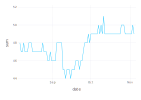

In [8]:
result_df = DataFrame()
for i in -90:0
    date = Date(2008, 11, 4) + Dates.Day(i)
    tmp_df = @chain intrade08_df begin
        @rsubset(:day < date)
        sort(:day, rev=true)
        unique([:state])
        @rtransform(:price_margin = :PriceD - :PriceR)
        @select(:state, :price_margin)
        innerjoin(pres08_df, on = [:state])
        @rtransform(:margin = :Obama - :McCain)
        @rtransform(:is_correct = sign(:margin) == sign(:price_margin))
        @combine(:sum = sum(:is_correct))
    end
    insertcols!(tmp_df, 1, :date => date)
    append!(result_df, tmp_df)
end
plot(result_df, x = :date, y = :sum, Geom.line)

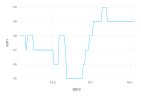

In [9]:
result_df = DataFrame()
for i in -90:0
    to_date = Date(2008, 11, 4) + Dates.Day(i)
    from_date = to_date - Dates.Day(7)
    tmp_df = @chain intrade08_df begin
        @rsubset(from_date <= :day < to_date)
        groupby(:state)
        @combine begin
            :PriceD_avg = mean(:PriceD)
            :PriceR_avg = mean(:PriceR)
        end
        @rtransform(:price_margin = :PriceD_avg - :PriceR_avg)
        @select(:state, :price_margin)
        innerjoin(pres08_df, on = [:state])
        @rtransform(:margin = :Obama - :McCain)
        @rtransform(:is_correct = sign(:margin) == sign(:price_margin))
        @combine(:sum = sum(:is_correct))
    end
    insertcols!(tmp_df, 1, :date => to_date)
    append!(result_df, tmp_df)
end
plot(result_df, x = :date, y = :sum, Geom.line)

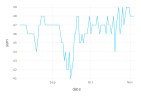

In [10]:
result_df = DataFrame()
for i in -90:0
    date = Date(2008, 11, 4) + Dates.Day(i)
    tmp_df = @chain polls08_df begin
        @rsubset(:middate < date)
        groupby([:state, :middate])
        @combine begin
            :Obama = mean(:Obama)
            :McCain = mean(:McCain)
        end
        sort(:middate, rev=true)
        unique([:state])
        @rtransform(:margin_pred = :Obama - :McCain)
        @select(:state, :margin_pred)
        innerjoin(pres08_df, on = [:state])
        @rtransform(:margin = :Obama - :McCain)
        @rtransform(:is_correct = sign(:margin) == sign(:margin_pred))
        @combine(:sum = sum(:is_correct))
    end
    insertcols!(tmp_df, 1, :date => date)
    append!(result_df, tmp_df)
end
plot(result_df, x = :date, y = :sum, Geom.line)

In [11]:
df = @chain intrade08_df begin
    @rsubset(:day < Date(2008, 11, 4))
    sort(:day, rev=true)
    unique([:state])
    @rtransform(:price_margin = :PriceD - :PriceR)
    @select(:state, :price_margin)
    innerjoin(pres08_df, on = [:state])
    @rtransform(:margin = :Obama - :McCain)
end
model = lm(@formula(margin ~ price_margin), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

margin ~ 1 + price_margin

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)   1.30265    1.64616     0.79    0.4326  -2.00542    4.61072
price_margin  0.229099   0.0199542  11.48    <1e-14   0.188999   0.269198
─────────────────────────────────────────────────────────────────────────

In [12]:
df = @chain polls08_df begin
    @rsubset(:middate < Date(2008, 11, 4))
    groupby([:state, :middate])
    @combine begin
        :Obama = mean(:Obama)
        :McCain = mean(:McCain)
    end
    sort(:middate, rev=true)
    unique([:state])
    @rtransform(:margin_pred = :Obama - :McCain)
    @select(:state, :margin_pred)
    innerjoin(pres08_df, on = [:state])
    @rtransform(:margin = :Obama - :McCain)
end
model = lm(@formula(margin ~ margin_pred), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

margin ~ 1 + margin_pred

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  0.709084   0.786955    0.90    0.3720  -0.872362    2.29053
margin_pred  1.10856    0.0406289  27.29    <1e-30   1.02692     1.19021
────────────────────────────────────────────────────────────────────────

In [13]:
df = @chain intrade12_df begin
    @rsubset(:day < Date(2012, 11, 6))
    sort(:day, rev=true)
    unique([:state])
    @rtransform(:price_margin = :PriceD - :PriceR)
    @select(:state, :price_margin)
    dropmissing
    innerjoin(pres12_df, on = [:state])
    @rtransform(:margin = :Obama - :Romney)
end
model = lm(@formula(margin ~ price_margin), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

margin ~ 1 + price_margin

Coefficients:
──────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)   -0.121989   1.57764    -0.08    0.9388  -3.31576    3.07179
price_margin   0.204391   0.0194804  10.49    <1e-12   0.164955   0.243827
──────────────────────────────────────────────────────────────────────────

In [14]:
df = @chain polls12_df begin
    @rsubset(:middate < Date(2012, 11, 6))
    groupby([:state, :middate])
    @combine begin
        :Obama = mean(:Obama)
        :Romney = mean(:Romney)
    end
    sort(:middate, rev=true)
    unique([:state])
    @rtransform(:margin_pred = :Obama - :Romney)
    @select(:state, :margin_pred)
    innerjoin(pres12_df, on = [:state])
    @rtransform(:margin = :Obama - :Romney)
end
model = lm(@formula(margin ~ margin_pred), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

margin ~ 1 + margin_pred

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  0.467909   0.772145    0.61    0.5476   -1.08727    2.02309
margin_pred  1.16409    0.0468587  24.84    <1e-27    1.06971    1.25847
────────────────────────────────────────────────────────────────────────

## 4.5.2

In [16]:
progresa_df = CSV.read("../../data/PREDICTION/conditional-cash-transfers/data/progresa.csv", DataFrame, missingstring=["NA"])

,treatment,pri2000s,pri2000v,t2000,t2000r,pri1994,pan1994,prd1994,pri1994s,pri1994v,pan1994s,pan1994v,prd1994s,prd1994v,t1994,t1994r,votos1994,avgpoverty,pobtot1994,villages
,Int64,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Float64,Float64?,Float64,Float64?,Float64,Float64?,Float64,Float64,Int64,Float64,Int64,Int64
1,1,40.824,73.1544,55.8052,60.5691,102,3,23,45.7599,77.2727,1.34588,2.27273,10.3184,17.4242,60.5646,67.0051,135,5.0,541,4
2,1,22.4419,73.5238,31.2209,50.2874,245,18,14,15.1154,65.6836,1.11052,4.82574,0.863736,3.75335,23.8144,55.8383,386,5.0,3289,2
3,1,38.9313,87.0307,47.0229,42.5254,52,8,4,7.98857,50.9804,1.22901,7.84314,0.614505,3.92157,21.6613,35.5401,141,4.5,1320,2
4,1,31.1688,71.2871,45.0216,49.7537,58,6,7,29.1622,73.4177,3.01677,7.59494,3.51957,8.86076,40.2237,56.8345,80,5.0,384,1
5,0,76.9231,78.9474,100.0,48.4076,30,0,38,20.1704,43.4783,0.0,0.0,25.5492,55.0725,46.3919,48.5915,69,5.0,307,1
6,0,23.8532,65.4088,37.3853,34.7921,128,0,20,32.8197,51.8219,0.0,0.0,5.12808,8.09717,63.3318,68.6111,247,5.0,840,6
7,1,47.3118,75.4286,64.8746,44.6429,47,8,9,12.2826,43.1193,2.09065,7.33945,2.35198,8.25688,28.4851,34.0625,109,5.0,790,1
8,1,21.4076,38.6243,58.0645,52.3546,30,1,99,9.9423,19.6078,0.33141,0.653595,32.8096,64.7059,61.6423,56.6667,186,5.0,632,2
9,1,56.4815,89.7059,71.2963,50.7463,274,0,30,178.163,89.8361,0.0,0.0,19.5069,9.83607,204.172,211.806,314,5.0,356,2


In [17]:
describe(progresa_df, :all)

,variable,mean,std,min,q25,median,q75,max,nunique,nmissing,first,last,eltype
,Symbol,Float64,Float64,Real,Float64,Float64,Float64,Real,Nothing,Int64,Real,Real,Type
1,treatment,0.669065,0.471115,0,0.0,1.0,1.0,1,,0,1,1,Int64
2,pri2000s,36.9126,18.3111,0.741004,26.1411,35.4962,45.4054,142.222,,0,40.824,37.6365,Float64
3,pri2000v,57.7918,17.5452,15.8065,44.511,57.3705,71.3018,100.0,,0,73.1544,53.3052,Float64
4,t2000,66.6715,30.9353,1.78458,55.1862,64.9776,73.4959,371.429,,0,55.8052,73.4856,Float64
5,t2000r,57.4441,8.53416,26.0465,52.0147,58.0205,63.3501,88.1481,,0,60.5691,62.3138,Float64
6,pri1994,243.336,148.351,0,130.0,219.0,330.0,763,,0,102,763,Int64
7,pan1994,34.1343,43.634,0,6.0,16.0,45.0,307,,0,3,60,Int64
8,prd1994,62.9185,77.91,0,10.0,34.0,89.0,528,,0,23,13,Int64
9,pri1994s,41.7413,21.0106,0.0,29.346,39.9248,52.1483,178.163,,0,45.7599,80.435,Float64


In [20]:
@chain progresa_df begin
    groupby(:treatment)
    @combine begin
        :t2000_mean = mean(:t2000)
        :pri2000s_mean = mean(:pri2000s)
    end
end

,treatment,t2000_mean,pri2000s_mean
,Int64,Float64,Float64
1,0,63.8148,34.489
2,1,68.0845,38.1114


In [21]:
lm(@formula(t2000 ~ treatment), progresa_df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

t2000 ~ 1 + treatment

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  63.8148      2.63097  24.26    <1e-80   58.6431     68.9865
treatment     4.26968     3.21649   1.33    0.1851   -2.05297    10.5923
────────────────────────────────────────────────────────────────────────

In [22]:
lm(@formula(pri2000s ~ treatment), progresa_df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

pri2000s ~ 1 + treatment

Coefficients:
───────────────────────────────────────────────────────────────────────
               Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────
(Intercept)  34.489      1.55383  22.20    <1e-71  31.4346      37.5433
treatment     3.6225     1.89963   1.91    0.0572  -0.111609     7.3566
───────────────────────────────────────────────────────────────────────

In [27]:
mdl = lm(@formula(pri2000s ~ treatment + avgpoverty + pobtot1994 + votos1994 + pri1994 + pan1994 + prd1994), progresa_df)
r2(mdl)

0.22059113118188967

In [28]:
mdl = lm(@formula(pri2000s ~ treatment + avgpoverty + log(pobtot1994) + t1994 + pri1994s + pan1994s + prd1994s), progresa_df)
r2(mdl)

0.5793612489562896

In [50]:
control_df = @rsubset(progresa_df, :treatment == 0)
treatment_df = @rsubset(progresa_df, :treatment == 1)

,treatment,pri2000s,pri2000v,t2000,t2000r,pri1994,pan1994,prd1994,pri1994s,pri1994v,pan1994s,pan1994v,prd1994s,prd1994v,t1994,t1994r,votos1994,avgpoverty,pobtot1994,villages
,Int64,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Float64,Float64?,Float64,Float64?,Float64,Float64?,Float64,Float64,Int64,Float64,Int64,Int64
1,1,40.824,73.1544,55.8052,60.5691,102,3,23,45.7599,77.2727,1.34588,2.27273,10.3184,17.4242,60.5646,67.0051,135,5.0,541,4
2,1,22.4419,73.5238,31.2209,50.2874,245,18,14,15.1154,65.6836,1.11052,4.82574,0.863736,3.75335,23.8144,55.8383,386,5.0,3289,2
3,1,38.9313,87.0307,47.0229,42.5254,52,8,4,7.98857,50.9804,1.22901,7.84314,0.614505,3.92157,21.6613,35.5401,141,4.5,1320,2
4,1,31.1688,71.2871,45.0216,49.7537,58,6,7,29.1622,73.4177,3.01677,7.59494,3.51957,8.86076,40.2237,56.8345,80,5.0,384,1
5,1,47.3118,75.4286,64.8746,44.6429,47,8,9,12.2826,43.1193,2.09065,7.33945,2.35198,8.25688,28.4851,34.0625,109,5.0,790,1
6,1,21.4076,38.6243,58.0645,52.3546,30,1,99,9.9423,19.6078,0.33141,0.653595,32.8096,64.7059,61.6423,56.6667,186,5.0,632,2
7,1,56.4815,89.7059,71.2963,50.7463,274,0,30,178.163,89.8361,0.0,0.0,19.5069,9.83607,204.172,211.806,314,5.0,356,2
8,1,36.6197,71.5596,51.1737,50.2304,81,4,14,40.3011,81.0,1.99018,4.0,6.96563,14.0,51.2471,68.4932,103,5.0,435,2
9,1,17.0543,30.9315,57.2674,53.6792,160,4,352,25.1185,29.9625,0.627963,0.749064,55.2607,65.9176,92.1535,66.8335,587,5.0,1423,9


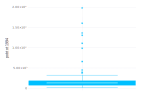

In [55]:
plot(control_df, y = :pobtot1994, Geom.boxplot)

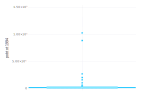

In [56]:
plot(treatment_df, y = :pobtot1994, Geom.boxplot)

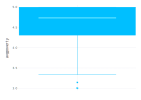

In [57]:
plot(treatment_df, y = :avgpoverty, Geom.boxplot)

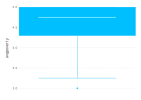

In [59]:
plot(control_df, y = :avgpoverty, Geom.boxplot)

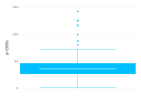

In [60]:
plot(treatment_df, y = :pri2000s, Geom.boxplot)

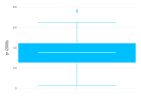

In [61]:
plot(control_df, y = :pri2000s, Geom.boxplot)

In [63]:
mdl = lm(@formula(t2000r ~ treatment + avgpoverty + log(pobtot1994) + pri1994v + pan1994v + prd1994v), progresa_df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

t2000r ~ 1 + treatment + avgpoverty + :(log(pobtot1994)) + pri1994v + pan1994v + prd1994v

Coefficients:
──────────────────────────────────────────────────────────────────────────────
                     Coef.  Std. Error      t  Pr(>|t|)   Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────────
(Intercept)      53.7838     8.89171     6.05    <1e-08  36.3047     71.263
treatment        -1.02828    0.865647   -1.19    0.2356  -2.72995     0.673397
avgpoverty       -1.91136    0.909217   -2.10    0.0361  -3.69868    -0.12404
log(pobtot1994)  -0.84055    0.496371   -1.69    0.0911  -1.81631     0.135206
pri1994v          0.190278   0.0573602   3.32    0.0010   0.0775203   0.303035
pan1994v          0.334992   0.0763707   4.39    <1e-04   0.184864    0.48

In [64]:
mdl = lm(@formula(pri2000v ~ treatment + avgpoverty + log(pobtot1994) + pri1994v + pan1994v + prd1994v), progresa_df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

pri2000v ~ 1 + treatment + avgpoverty + :(log(pobtot1994)) + pri1994v + pan1994v + prd1994v

Coefficients:
──────────────────────────────────────────────────────────────────────────────
                     Coef.  Std. Error      t  Pr(>|t|)  Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────────
(Intercept)      42.3614    13.7116      3.09    0.0021  15.4073    69.3154
treatment         0.781325   1.33489     0.59    0.5587  -1.84277    3.40542
avgpoverty        3.82361    1.40207     2.73    0.0067   1.06744    6.57978
log(pobtot1994)  -2.37734    0.765438   -3.11    0.0020  -3.88202   -0.872654
pri1994v          0.331996   0.0884533   3.75    0.0002   0.158116   0.505876
pan1994v         -0.512416   0.117769   -4.35    <1e-04  -0.743924  -0.280908

In [65]:
mdl = lm(@formula(pri2000v ~ treatment * avgpoverty + (treatment * avgpoverty)^2 + log(pobtot1994)), progresa_df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

pri2000v ~ 1 + treatment + avgpoverty + :((treatment * avgpoverty) ^ 2) + :(log(pobtot1994)) + treatment & avgpoverty

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────
                                  Coef.  Std. Error      t  Pr(>|t|)     Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                    64.3286    16.2085     3.97    <1e-04    32.4666      96.1905
treatment                     112.829     65.4009     1.73    0.0852   -15.7331     241.391
avgpoverty                      5.93641    2.98313    1.99    0.0473     0.0723216   11.8005
(treatment * avgpoverty) ^ 2    6.65259    3.49842    1.90    0.0579    -0.224437    13.5296
log(pobtot1994)      

## 4.5.3

In [3]:
transfer_df = CSV.read("../../data/PREDICTION/gov-transfer-brazil/data/transfer.csv", DataFrame, missingstring=["NA"])

,id,state,region,literate91,educ91,poverty91,poverty80,educ80,pop82
,Int64,String3,String3,Float64?,Float64?,Float64,Float64?,Float64?,Int64
1,55,AC,N,0.727811,3.87306,0.63582,0.6608,1.7,13937
2,60,AC,N,0.477099,2.48047,0.75124,0.795,1.0,19613
3,65,AC,N,0.718631,3.21673,0.66797,0.4121,0.9,9343
4,70,AC,N,0.732984,3.96631,0.53811,0.4131,0.8,9728
5,71,AC,N,0.552023,3.00588,0.69243,0.4808,1.0,23592
6,73,AC,N,0.68984,3.8877,0.59126,0.5765,1.5,14701
7,78,AM,N,0.6875,4.04202,0.64107,0.5278,1.5,14994
8,81,AM,N,0.779923,3.60156,0.72651,0.7011,1.4,16107
9,82,AM,N,0.539062,2.44386,0.51972,0.3935,1.7,9123


In [4]:
describe(transfer_df, :all)

,variable,mean,std,min,q25,median,q75,max,nunique,nmissing,first,last,eltype
,Symbol,Union…,Union…,Any,Union…,Union…,Union…,Any,Union…,Int64,Any,Any,Type
1,id,2705.06,1503.8,55,1538.0,2516.0,3962.0,5560,,0,55,5560,Int64
2,state,,,AC,,,,TO,25,0,AC,GO,String3
3,region,,,CO,,,,SE,5,0,N,CO,String3
4,literate91,0.788358,0.164492,0.242291,0.647308,0.843983,0.934783,1.0,,1,0.727811,0.925258,"Union{Missing, Float64}"
5,educ91,4.58554,1.42789,0.725962,3.4017,4.67539,5.75573,8.04706,,1,3.87306,5.16062,"Union{Missing, Float64}"
6,poverty91,0.602428,0.227285,0.03482,0.427775,0.64363,0.80663,0.94141,,0,0.63582,0.46174,Float64
7,poverty80,0.593381,0.218795,0.0487,0.419925,0.61615,0.7826,0.9693,,1,0.6608,0.5472,"Union{Missing, Float64}"
8,educ80,1.90773,0.9878,0.1,1.0,1.8,2.7,5.1,,1,1.7,2.5,"Union{Missing, Float64}"
9,pop82,13775.5,4474.01,7504,9929.0,12923.0,17155.0,23751,,0,13937,7929,Int64


In [6]:
function decide_group_and_score(population; threshold)
    sort!(threshold)
    abs_diffs = []
    for threshold_i in threshold
        append!(abs_diffs, abs(population - threshold_i))
    end
    group = argmin(abs_diffs)
    score = population / threshold[group] - 1
    return group, score
end
thresholds = [10188, 13584, 16980]
transfer_df = @chain transfer_df begin
    @rtransform begin
        :group = decide_group_and_score(:pop82; threshold = thresholds)[1]
        :score = decide_group_and_score(:pop82; threshold = thresholds)[2]
    end
end

,id,state,region,literate91,educ91,poverty91,poverty80,educ80,pop82,group,score
,Int64,String3,String3,Float64?,Float64?,Float64,Float64?,Float64?,Int64,Int64,Float64
1,55,AC,N,0.727811,3.87306,0.63582,0.6608,1.7,13937,2,0.0259865
2,60,AC,N,0.477099,2.48047,0.75124,0.795,1.0,19613,3,0.155065
3,65,AC,N,0.718631,3.21673,0.66797,0.4121,0.9,9343,1,-0.0829407
4,70,AC,N,0.732984,3.96631,0.53811,0.4131,0.8,9728,1,-0.0451512
5,71,AC,N,0.552023,3.00588,0.69243,0.4808,1.0,23592,3,0.389399
6,73,AC,N,0.68984,3.8877,0.59126,0.5765,1.5,14701,2,0.0822291
7,78,AM,N,0.6875,4.04202,0.64107,0.5278,1.5,14994,2,0.103799
8,81,AM,N,0.779923,3.60156,0.72651,0.7011,1.4,16107,3,-0.0514134
9,82,AM,N,0.539062,2.44386,0.51972,0.3935,1.7,9123,1,-0.104535


In [7]:
sub_transfer_df = @chain transfer_df begin
    @rsubset(abs(:score) <= 0.03)
end

,id,state,region,literate91,educ91,poverty91,poverty80,educ80,pop82,group,score
,Int64,String3,String3,Float64?,Float64?,Float64,Float64?,Float64?,Int64,Int64,Float64
1,55,AC,N,0.727811,3.87306,0.63582,0.6608,1.7,13937,2,0.0259865
2,98,AM,N,0.531697,2.05328,0.70826,0.6285,1.1,13477,2,-0.00787691
3,114,AM,N,0.458333,1.36858,0.81287,0.8229,0.4,10041,1,-0.0144287
4,116,AM,N,0.878412,4.41191,0.79858,0.7895,1.5,13349,2,-0.0172998
5,119,AM,N,0.611465,2.63462,0.63477,0.6197,1.4,10379,1,0.0187475
6,131,AM,N,0.312409,1.2838,0.87269,0.5575,0.4,16869,3,-0.0065371
7,214,PA,N,0.78,3.25304,0.7595,0.6358,1.5,13793,2,0.0153857
8,229,PA,N,0.793478,4.69708,0.71293,0.6483,1.7,9998,1,-0.0186494
9,256,PA,N,0.911271,5.19904,0.65172,0.6888,2.4,10087,1,-0.00991362


In [8]:
model = lm(@formula(educ91 ~ score), sub_transfer_df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

educ91 ~ 1 + score

Coefficients:
───────────────────────────────────────────────────────────────────────
               Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────
(Intercept)  4.53898   0.0805093  56.38    <1e-99   4.38054     4.69743
score        9.5311    4.71296     2.02    0.0440   0.255808   18.8064
───────────────────────────────────────────────────────────────────────

In [9]:
model = lm(@formula(poverty91 ~ score), sub_transfer_df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

poverty91 ~ 1 + score

Coefficients:
──────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)  Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)   0.609199   0.0131402  46.36    <1e-99   0.583338   0.635059
score        -1.56363    0.769219   -2.03    0.0430  -3.07748   -0.0497742
──────────────────────────────────────────────────────────────────────────

In [10]:
model = lm(@formula(literate91 ~ score), sub_transfer_df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

literate91 ~ 1 + score

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  0.788848  0.00924079  85.37    <1e-99  0.770662    0.807034
score        1.08683   0.540949     2.01    0.0454  0.0222256   2.15144
────────────────────────────────────────────────────────────────────────

In [11]:
@chain sub_transfer_df begin
    @rtransform(:is_pos = :score > 0 ? true : false)
    groupby(:is_pos)
    @combine begin
        :educ91_mean = mean(:educ91)
        :poverty91_mean = mean(:poverty91)
        :literate91_mean = mean(:literate91)
    end
end

,is_pos,educ91_mean,poverty91_mean,literate91_mean
,Bool,Float64,Float64,Float64
1,0,4.33173,0.639959,0.766321
2,1,4.75139,0.577528,0.811985


In [12]:
model = lm(@formula(educ91 ~ score), @rsubset(transfer_df, abs(:score) <= 0.01))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

educ91 ~ 1 + score

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)   4.66136    0.137298  33.95    <1e-57    4.38912    4.93359
score        43.4487    22.8646     1.90    0.0601   -1.88744   88.7849
────────────────────────────────────────────────────────────────────────

In [13]:
model = lm(@formula(educ91 ~ score), @rsubset(transfer_df, abs(:score) <= 0.02))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

educ91 ~ 1 + score

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)   4.58193   0.0994003  46.10    <1e-99    4.38592    4.77794
score        22.7133    8.62829     2.63    0.0091    5.69922   39.7274
────────────────────────────────────────────────────────────────────────

In [14]:
model = lm(@formula(educ91 ~ score), @rsubset(transfer_df, abs(:score) <= 0.03))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

educ91 ~ 1 + score

Coefficients:
───────────────────────────────────────────────────────────────────────
               Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────
(Intercept)  4.53898   0.0805093  56.38    <1e-99   4.38054     4.69743
score        9.5311    4.71296     2.02    0.0440   0.255808   18.8064
───────────────────────────────────────────────────────────────────────

In [15]:
model = lm(@formula(educ91 ~ score), @rsubset(transfer_df, abs(:score) <= 0.04))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

educ91 ~ 1 + score

Coefficients:
───────────────────────────────────────────────────────────────────────
               Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────
(Intercept)  4.55135    0.071458  63.69    <1e-99    4.41086    4.69184
score        3.70856    3.17687    1.17    0.2438   -2.53742    9.95454
───────────────────────────────────────────────────────────────────────

In [16]:
model = lm(@formula(educ91 ~ score), @rsubset(transfer_df, abs(:score) <= 0.05))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

educ91 ~ 1 + score

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  4.5937      0.064968  70.71    <1e-99    4.46604    4.72136
score        0.484821    2.3096     0.21    0.8338   -4.05343    5.02307
────────────────────────────────────────────────────────────────────────

In [17]:
model = lm(@formula(poverty91 ~ score), @rsubset(transfer_df, abs(:score) <= 0.01))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

poverty91 ~ 1 + score

Coefficients:
──────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)   Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)   0.574802   0.0231885  24.79    <1e-44    0.528823    0.62078
score        -5.16825    3.86163    -1.34    0.1837  -12.8251      2.48865
──────────────────────────────────────────────────────────────────────────

In [18]:
model = lm(@formula(poverty91 ~ score), @rsubset(transfer_df, abs(:score) <= 0.02))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

poverty91 ~ 1 + score

Coefficients:
──────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)  Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)   0.592585   0.0163707  36.20    <1e-89   0.560303   0.624866
score        -2.84142    1.42103    -2.00    0.0469  -5.64354   -0.0392921
──────────────────────────────────────────────────────────────────────────

In [19]:
model = lm(@formula(poverty91 ~ score), @rsubset(transfer_df, abs(:score) <= 0.03))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

poverty91 ~ 1 + score

Coefficients:
──────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)  Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)   0.609199   0.0131402  46.36    <1e-99   0.583338   0.635059
score        -1.56363    0.769219   -2.03    0.0430  -3.07748   -0.0497742
──────────────────────────────────────────────────────────────────────────

In [20]:
model = lm(@formula(poverty91 ~ score), @rsubset(transfer_df, abs(:score) <= 0.04))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

poverty91 ~ 1 + score

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)   0.608612   0.0112545  54.08    <1e-99   0.586485   0.630739
score        -0.79173    0.50035    -1.58    0.1144  -1.77546    0.191998
─────────────────────────────────────────────────────────────────────────

In [21]:
model = lm(@formula(poverty91 ~ score), @rsubset(transfer_df, abs(:score) <= 0.05))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

poverty91 ~ 1 + score

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)   0.603073   0.0102565  58.80    <1e-99    0.58292   0.623227
score        -0.324035   0.364616   -0.89    0.3746   -1.04049   0.392417
─────────────────────────────────────────────────────────────────────────

In [22]:
model = lm(@formula(literate91 ~ score), @rsubset(transfer_df, abs(:score) <= 0.01))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

literate91 ~ 1 + score

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  0.802487   0.0155497  51.61    <1e-75   0.771655    0.83332
score        4.06112    2.58953     1.57    0.1198  -1.07343     9.19568
────────────────────────────────────────────────────────────────────────

In [23]:
model = lm(@formula(literate91 ~ score), @rsubset(transfer_df, abs(:score) <= 0.02))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

literate91 ~ 1 + score

Coefficients:
─────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)   Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  0.792691   0.0113694  69.72    <1e-99   0.770272    0.815111
score        1.88132    0.986907    1.91    0.0580  -0.0647538   3.8274
─────────────────────────────────────────────────────────────────────────

In [24]:
model = lm(@formula(literate91 ~ score), @rsubset(transfer_df, abs(:score) <= 0.03))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

literate91 ~ 1 + score

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  0.788848  0.00924079  85.37    <1e-99  0.770662    0.807034
score        1.08683   0.540949     2.01    0.0454  0.0222256   2.15144
────────────────────────────────────────────────────────────────────────

In [25]:
model = lm(@formula(literate91 ~ score), @rsubset(transfer_df, abs(:score) <= 0.04))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

literate91 ~ 1 + score

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  0.788868  0.00825664  95.54    <1e-99   0.772634   0.805101
score        0.350637  0.367072     0.96    0.3401  -0.371057   1.07233
────────────────────────────────────────────────────────────────────────

In [26]:
model = lm(@formula(literate91 ~ score), @rsubset(transfer_df, abs(:score) <= 0.05))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

literate91 ~ 1 + score

Coefficients:
─────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  0.79442   0.00742907  106.93    <1e-99   0.779822   0.809018
score        0.163439  0.264102      0.62    0.5363  -0.355508   0.682387
─────────────────────────────────────────────────────────────────────────

In [27]:
model = lm(@formula(educ80 ~ score), @rsubset(transfer_df, abs(:score) <= 0.03))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

educ80 ~ 1 + score

Coefficients:
───────────────────────────────────────────────────────────────────────
               Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────
(Intercept)  1.88844    0.055601  33.96    <1e-99   1.77902     1.99787
score        7.05214    3.25485    2.17    0.0311   0.646482   13.4578
───────────────────────────────────────────────────────────────────────

In [28]:
model = lm(@formula(poverty80 ~ score), @rsubset(transfer_df, abs(:score) <= 0.03))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

poverty80 ~ 1 + score

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)   0.605613   0.0127545  47.48    <1e-99   0.580512  0.630715
score        -1.4467     0.74664    -1.94    0.0536  -2.91612   0.0227166
─────────────────────────────────────────────────────────────────────────